In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2

from trasim_simplified.core.kinematics.cfm import get_cf_func
from trasim_simplified.core.constant import CFM

dt = 0.1
cf_name = CFM.IDM
cf_func = get_cf_func(cf_name)

In [2]:
from trasim_simplified.util.tools import load_from_pickle
from trasim_simplified.core.constant import TrackInfo as TI, Prefix

# 读取轨迹
traj_s_full_ori: dict[str, dict] = load_from_pickle(r"E:\PyProject\car-following-model-test\tests\data\ori_dec_acc_traj_s.pkl")
traj_s_cut_pos = {v_id: len(df_pair) for v_id, df_pair in traj_s_full_ori["dec"].items()}

traj_s_full: dict[str, pd.DataFrame] = {v_id: pd.concat([df_pair, traj_s_full_ori["acc"][v_id]]) for v_id, df_pair in traj_s_full_ori["dec"].items()}
obs_x_s = [traj_s_full[k][TI.x] for k in traj_s_full.keys()]
obs_v_s = [traj_s_full[k][TI.v] for k in traj_s_full.keys()]
obs_lx_s = [traj_s_full[k][Prefix.leader + TI.x] for k in traj_s_full.keys()]
obs_lv_s = [traj_s_full[k][Prefix.leader + TI.v] for k in traj_s_full.keys()]
leaderL_s = [traj_s_full[k][Prefix.leader + TI.v_Length].unique()[0] for k in traj_s_full.keys()]
id_s = [k for k in traj_s_full.keys()]
print(len(id_s))

133


In [3]:
from trasim_simplified.util.calibrate.clb_cf_model import clb_run

# 跟驰模型参数标定
results = clb_run(cf_func=cf_func, cf_name=cf_name,
                  obs_x_s=obs_x_s, obs_v_s=obs_v_s, obs_lx_s=obs_lx_s, obs_lv_s=obs_lv_s, leaderL_s=leaderL_s,
                  dt=0.1, seed=2024, drawing=0, n_jobs=-1)

Using geatpy


In [4]:
from trasim_simplified.util.calibrate.clb_cf_model import aggregate_result

avg_obj, avg_param, std_obj, std_param = aggregate_result(results)
print(f"avg_obj: {avg_obj}\navg_param: {avg_param}\nstd_obj: {std_obj}\nstd_param: {std_param}")

avg_obj: 37.90091846384753
avg_param: [ 3.48905585  0.         27.42778403  1.12423445  2.57409462  4.82353377
  4.47368421]
std_obj: 22.377639155110224
std_param: [ 2.08773262  0.         12.89565967  0.58448736  2.32741974  3.89712139
  3.51704538]


In [5]:
from trasim_simplified.util.calibrate.clb_cf_model import clb_param_to_df

param_df = clb_param_to_df(id_s, results, cf_name)
param_df.to_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_param_df.pkl")
param_df

,s0,s1,v0,T,omega,d,delta,v_ID,ObjV
0,3.367405,-0.0,50.000000,0.586548,1.195860,0.318813,10.0,280,20.446222
1,2.188234,0.0,14.898263,0.140734,2.226179,1.893512,1.0,282,72.459121
2,6.313324,-0.0,16.045856,1.583061,0.845246,9.671251,9.0,298,54.787953
3,0.879316,-0.0,32.721860,0.672054,1.656269,3.744626,1.0,302,25.827953
4,4.602900,0.0,41.824750,1.477022,1.692826,8.403208,3.0,322,33.869920
...,...,...,...,...,...,...,...,...,...
128,1.650314,0.0,44.028852,0.937281,1.371234,4.418636,1.0,2761,41.097679
129,4.003811,0.0,19.466078,1.156578,1.227376,9.999991,2.0,2764,34.202032
130,4.889622,-0.0,22.636509,0.376377,1.576178,0.714813,1.0,2775,4.447199
131,1.246643,0.0,14.800041,0.995808,0.868858,0.103238,3.0,2779,49.210656


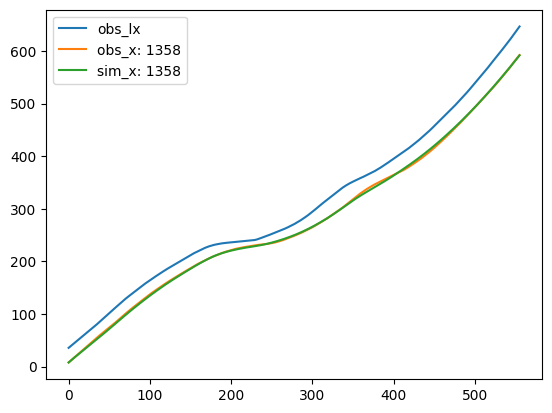

In [6]:
from trasim_simplified.util.calibrate.clb_cf_model import show_traj
import random

pos = random.choice(range(len(id_s)))
# pos = param_df[param_df[TI.v_ID] == 2778].index[0]

target = param_df[param_df[TI.v_ID] == id_s[pos]]
obs_x = obs_x_s[pos]
obs_v = obs_v_s[pos]
obs_lx = obs_lx_s[pos]
obs_lv = obs_lv_s[pos]
leaderL = leaderL_s[pos]
show_traj(cf_name, target.to_numpy().reshape(-1), dt, obs_x, obs_v, obs_lx, obs_lv, leaderL, traj_step=None, v_ID=id_s[pos])

In [7]:
from trasim_simplified.util.tools import save_to_pickle
from trasim_simplified.util.calibrate.clb_cf_model import get_clb_traj

clb_traj_s = get_clb_traj(traj_s_full, traj_s_cut_pos, param_df, cf_func, cf_name, dt)

save_to_pickle(clb_traj_s,
               r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_traj_s.pkl")